In [1]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io, transform, color
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm
import cv2
import shutil

C:\Users\abdullah\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load and preprocess training images
image_folder   = 'C:\\Users\\abdullah\\Desktop\\All Files\\Abdullah file\\Learning hub\\Compettetion\\Tumor classification\\images\\images'

In [3]:
train  = pd.read_csv('trainset.csv')
test   = pd.read_csv('testset.csv')

In [4]:
images = os.listdir(image_folder)
id_train = dict(zip(train['Id'], train['Class']))

In [5]:
# create a list for both images and labels
train_imgs = []
train_label = []

In [6]:
for cla,id in tqdm(zip(train['Class'],train['Id'])):
    try:
        i = cv2.imread(image_folder+'\\'+str(id)+'.png')
        train_imgs.append(i)
        train_label.append(cla)
    except:
        pass

539it [00:06, 88.46it/s]


In [7]:
test_imgs = []
for id in tqdm(test['Id']):
    try:
        i = cv2.imread(image_folder+'\\'+str(id)+'.png')
        test_imgs.append(i)
    except:
        pass

100%|██████████| 229/229 [00:02<00:00, 86.58it/s]


In [8]:
len(test_imgs)

229

In [9]:
test_imgs[0].shape

(467, 551, 3)

In [10]:
L1=[]
L2=[]
for img1 in tqdm(train_imgs):
    filtered_train = cv2.pyrMeanShiftFiltering(img1, 21, 51)
    L1.append(filtered_train)
for img2 in tqdm(test_imgs):
    filtered_test = cv2.pyrMeanShiftFiltering(img2, 21, 51)
    L2.append(filtered_test)
print(len(L1))
print(len(L2))

100%|██████████| 229/229 [04:37<00:00,  1.21s/it]

539
229


In [11]:
train_imgs = L1
test_imgs =L2

# resize the images

In [12]:
New_Images = []
# Loop through each image in X_train and resize
for image in train_imgs:
    image = cv2.resize(image, (180, 180))
    New_Images.append(image)

# Convert the list of resized images back to a NumPy array
    New_Train = np.array(New_Images)

In [13]:
len(New_Images)

539

In [14]:
New_Images = []
# Loop through each image in X_train and resize
for image in test_imgs:
    image = cv2.resize(image, (180, 180))
    New_Images.append(image)

# Convert the list of resized images back to a NumPy array
New_Test = np.array(New_Images)

In [15]:
print(len(New_Test))

229


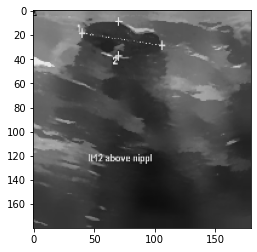

In [16]:
plt.imshow(New_Test[0])

# Normalize images

In [17]:
New_Train = New_Train/255
New_Test = New_Test/255

In [18]:
print(New_Train[0].shape)

(180, 180, 3)


In [19]:
Train_feature = New_Train.reshape(New_Train.shape[0], -1)
Test_feature = New_Test.reshape(New_Test.shape[0], -1)

In [20]:
Train_feature.shape

(539, 97200)

In [21]:
print(type(Train_feature))

<class 'numpy.ndarray'>


In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state=42,  sampling_strategy='auto')
smote.fit(Train_feature, train_label)
X_resampled, y_resampled = smote.fit_resample(Train_feature, train_label)

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled  , test_size=0.3, random_state=42)

In [ ]:
# X_train, X_test, y_train, y_test

In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [24]:
pca = PCA(n_components=180 )  # You can adjust the number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [26]:

pickle.dump(pca,open('pca.sav','wb'))

In [27]:
pcc = pickle.load(open('pca.sav','rb'))

In [29]:
X_train_pca.shape, X_test_pca.shape

((625, 180), (269, 180))

# **Modeling**

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'C': [0.01, 0.1, 1,2,3,4,5,6,7,8,9 ,10,20,30,35,50,75,90, 100],
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'coef0': [-2, -1, 0, 1, 2],
    'shrinking': [True, False],
    'class_weight': [None, 'balanced'],
    'decision_function_shape': ['ovo', 'ovr']
    # Add more hyperparameters and values here as needed
}


svm_classifier = SVC()

# Create a scorer using F1-score
scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_classifier,
    param_distributions=param_grid,
    scoring=scorer,
    n_iter=500,  # Number of parameter settings that are sampled
    cv=5,       # Number of folds in cross-validation
    verbose=2,
    n_jobs=-1   # Use all available CPU cores
)

# Fit the RandomizedSearchCV on your training data
random_search.fit(X_train_pca, y_train)

# Get the best estimator from the search
best_svm_classifier = random_search.best_estimator_

# Make predictions using the best model
y_pred1 = best_svm_classifier.predict(X_train_pca)
y_pred2 = best_svm_classifier.predict(X_test_pca)

# Calculate F1-score on the test set
f1_test_score = f1_score(y_test, y_pred2, average='weighted')
accuracy2 = accuracy_score(y_test, y_pred2)
# Generate classification report
class_report2 = classification_report(y_test, y_pred2)
print("Classification Report:\n", class_report2)

print("Best Parameters:", random_search.best_params_)
print("Best F1-score:", f1_test_score)
print('Accuracy for best ',accuracy2)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Classification Report:
               precision    recall  f1-score   support

      Benign       0.77      0.93      0.84        54
   Malignant       0.98      0.80      0.88        65
      Normal       0.92      0.93      0.93        61

    accuracy                           0.88       180
   macro avg       0.89      0.89      0.88       180
weighted avg       0.90      0.88      0.88       180

Best Parameters: {'shrinking': True, 'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'decision_function_shape': 'ovo', 'coef0': 2, 'class_weight': None, 'C': 6}
Best F1-score: 0.8844604012198789
Accuracy for best  0.8833333333333333


In [31]:
from sklearn.metrics import make_scorer, f1_score
svm_classifier = SVC(kernel='rbf', C=6, gamma=0.001,class_weight=None,decision_function_shape='ovo',shrinking=True)
svm_classifier.fit(X_train_pca, y_train)

# Make predictions
y_pred1 = svm_classifier.predict(X_train_pca)
y_pred2 = svm_classifier.predict(X_test_pca)


accuracy2 = accuracy_score(y_test, y_pred2)
f1_test_score = f1_score(y_test, y_pred2, average='weighted')


print("Accuracy2:", accuracy2)
print("F1 weightd score",f1_test_score)
# Calculate confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix1:\n", conf_matrix2)

# Generate classification report
class_report2 = classification_report(y_test, y_pred2)

print("Classification Report:\n", class_report2)

Accuracy2: 0.9219330855018587
F1 weightd score 0.9210271731684433
Confusion Matrix1:
 [[81  8  7]
 [ 3 83  2]
 [ 1  0 84]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.95      0.84      0.90        96
   Malignant       0.91      0.94      0.93        88
      Normal       0.90      0.99      0.94        85

    accuracy                           0.92       269
   macro avg       0.92      0.93      0.92       269
weighted avg       0.92      0.92      0.92       269



In [32]:
X_test_pca_sub = pca.transform(Test_feature)
predictions = svm_classifier.predict(X_test_pca_sub)

In [33]:
pickle.dump(svm_classifier,open('model_SVM.sav','wb'))

In [34]:
submit = pd.read_csv('sample_submition4.csv')
submit

,Id,Class
0,8560,A
1,7920,A
2,8993,A
3,8126,A
4,9912,A
...,...,...
224,8343,A
225,1255,A
226,4573,A
227,3919,A
